In [1]:
from dotenv import load_dotenv, find_dotenv
import os

import openai

_ = load_dotenv(find_dotenv())
# openai.api_key = os.getenv('OPENAI_API_KEY')
openai.api_key = '-'

### https://github.com/openai/openai-cookbook/blob/main/examples/Recommendation_using_embeddings.ipynb

In [2]:
# imports
import pandas as pd
import pickle

from utils.embeddings_utils import (
    get_embedding,
    distances_from_embeddings,
    tsne_components_from_embeddings,
    chart_from_components,
    indices_of_nearest_neighbors_from_distances,
)

# constants
EMBEDDING_MODEL = "text-embedding-ada-002"

In [10]:
# load data (full dataset available at http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html)
dataset_path = "data/AG_news_samples.csv"
df = pd.read_csv(dataset_path)

# print dataframe
n_examples = 5
df.head(n_examples)

title  \
0                                    World Briefings   
1  Nvidia Puts a Firewall on a Motherboard (PC Wo...   
2                Olympic joy in Greek, Chinese press   
3                          U2 Can iPod with Pictures   
4                                  The Dream Factory   

                                         description  label_int     label  
0  BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime M...          1     World  
1  PC World - Upcoming chip set will include buil...          4  Sci/Tech  
2  Newspapers in Greece reflect a mixture of exhi...          2    Sports  
3  SAN JOSE, Calif. -- Apple Computer (Quote, Cha...          4  Sci/Tech  
4  Any product, any shape, any size -- manufactur...          4  Sci/Tech

In [11]:
# print the title, description, and label of each example
for idx, row in df.head(n_examples).iterrows():
    print("")
    print(f"Title: {row['title']}")
    print(f"Description: {row['description']}")
    print(f"Label: {row['label']}")


Title: World Briefings
Description: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.
Label: World

Title: Nvidia Puts a Firewall on a Motherboard (PC World)
Description: PC World - Upcoming chip set will include built-in security features for your PC.
Label: Sci/Tech

Title: Olympic joy in Greek, Chinese press
Description: Newspapers in Greece reflect a mixture of exhilaration that the Athens Olympics proved successful, and relief that they passed off without any major setback.
Label: Sports

Title: U2 Can iPod with Pictures
Description: SAN JOSE, Calif. -- Apple Computer (Quote, Chart) unveiled a batch of new iPods, iTunes software and promos designed to keep it atop the heap of digital music players.
Label: Sci/Tech

Title: The Dream Factory
Description: Any product, any shape, any size -- manufactured o

In [12]:
# establish a cache of embeddings to avoid recomputing
# cache is a dict of tuples (text, model) -> embedding, saved as a pickle file

# set path to embedding cache
embedding_cache_path = "data/recommendations_embeddings_cache.pkl"

# load the cache if it exists, and save a copy to disk
try:
    embedding_cache = pd.read_pickle(embedding_cache_path)
except FileNotFoundError:
    embedding_cache = {}
with open(embedding_cache_path, "wb") as embedding_cache_file:
    pickle.dump(embedding_cache, embedding_cache_file)

# define a function to retrieve embeddings from the cache if present, and otherwise request via the API
def embedding_from_string(
    string: str,
    model: str = EMBEDDING_MODEL,
    embedding_cache=embedding_cache
) -> list:
    """Return embedding of given string, using a cache to avoid recomputing."""
    if (string, model) not in embedding_cache.keys():
        embedding_cache[(string, model)] = get_embedding(string, model)
        with open(embedding_cache_path, "wb") as embedding_cache_file:
            pickle.dump(embedding_cache, embedding_cache_file)
    return embedding_cache[(string, model)]

In [13]:
# as an example, take the first description from the dataset
example_string = df["description"].values[0]
print(f"\nExample string: {example_string}")

# print the first 10 dimensions of the embedding
example_embedding = embedding_from_string(example_string)
print(f"\nExample embedding: {example_embedding[:10]}...")


Example string: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.

Example embedding: [-0.01071077398955822, -0.022362446412444115, -0.00883542187511921, -0.0254171434789896, 0.031423427164554596, 0.010723662562668324, -0.016717055812478065, 0.004195375367999077, -0.008074969984591007, -0.02142154797911644]...


In [14]:
def print_recommendations_from_strings(
    strings: list[str],
    index_of_source_string: int,
    k_nearest_neighbors: int = 1,
    model=EMBEDDING_MODEL,
) -> list[int]:
    """Print out the k nearest neighbors of a given string."""
    # get embeddings for all strings
    embeddings = [embedding_from_string(string, model=model) for string in strings]
    # get the embedding of the source string
    query_embedding = embeddings[index_of_source_string]
    # get distances between the source embedding and other embeddings (function from utils.embeddings_utils.py)
    distances = distances_from_embeddings(query_embedding, embeddings, distance_metric="cosine")
    # get indices of nearest neighbors (function from utils.utils.embeddings_utils.py)
    indices_of_nearest_neighbors = indices_of_nearest_neighbors_from_distances(distances)

    # print out source string
    query_string = strings[index_of_source_string]
    print(f"Source string: {query_string}")
    # print out its k nearest neighbors
    k_counter = 0
    for i in indices_of_nearest_neighbors:
        # skip any strings that are identical matches to the starting string
        if query_string == strings[i]:
            continue
        # stop after printing out k articles
        if k_counter >= k_nearest_neighbors:
            break
        k_counter += 1

        # print out the similar strings and their distances
        print(
            f"""
        --- Recommendation #{k_counter} (nearest neighbor {k_counter} of {k_nearest_neighbors}) ---
        String: {strings[i]}
        Distance: {distances[i]:0.3f}"""
        )

    return indices_of_nearest_neighbors

In [15]:
article_descriptions = df["description"].tolist()

tony_blair_articles = print_recommendations_from_strings(
    strings=article_descriptions,  # let's base similarity off of the article description
    index_of_source_string=0,  # let's look at articles similar to the first one about Tony Blair
    k_nearest_neighbors=2,  # let's look at the 5 most similar articles
)

Source string: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.

        --- Recommendation #1 (nearest neighbor 1 of 2) ---
        String: THE re-election of British Prime Minister Tony Blair would be seen as an endorsement of the military action in Iraq, Prime Minister John Howard said today.
        Distance: 0.153

        --- Recommendation #2 (nearest neighbor 2 of 2) ---
        String: LONDON, England -- A US scientist is reported to have observed a surprising jump in the amount of carbon dioxide, the main greenhouse gas.
        Distance: 0.160


In [17]:
chipset_security_articles = print_recommendations_from_strings(
    strings=article_descriptions,  # let's base similarity off of the article description
    index_of_source_string=1,  # let's look at articles similar to the second one about a more secure chipset
    k_nearest_neighbors=2,  # let's look at the 5 most similar articles
)

Source string: PC World - Upcoming chip set will include built-in security features for your PC.

        --- Recommendation #1 (nearest neighbor 1 of 2) ---
        String: PC World - Updated antivirus software for businesses adds intrusion prevention features.
        Distance: 0.112

        --- Recommendation #2 (nearest neighbor 2 of 2) ---
        String: PC World - The one-time World Class Product of the Year PDA gets a much-needed upgrade.
        Distance: 0.145


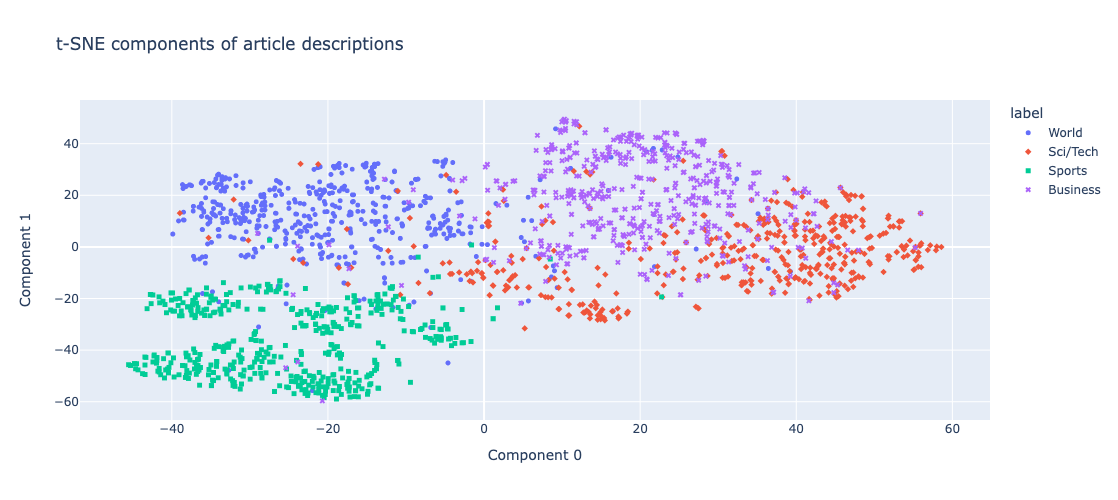

In [18]:
# get embeddings for all article descriptions
embeddings = [embedding_from_string(string) for string in article_descriptions]
# compress the 2048-dimensional embeddings into 2 dimensions using t-SNE
tsne_components = tsne_components_from_embeddings(embeddings)
# get the article labels for coloring the chart
labels = df["label"].tolist()

chart_from_components(
    components=tsne_components,
    labels=labels,
    strings=article_descriptions,
    width=600,
    height=500,
    title="t-SNE components of article descriptions",
)

In [19]:
# create labels for the recommended articles
def nearest_neighbor_labels(
    list_of_indices: list[int],
    k_nearest_neighbors: int = 5
) -> list[str]:
    """Return a list of labels to color the k nearest neighbors."""
    labels = ["Other" for _ in list_of_indices]
    source_index = list_of_indices[0]
    labels[source_index] = "Source"
    for i in range(k_nearest_neighbors):
        nearest_neighbor_index = list_of_indices[i + 1]
        labels[nearest_neighbor_index] = f"Nearest neighbor (top {k_nearest_neighbors})"
    return labels


tony_blair_labels = nearest_neighbor_labels(tony_blair_articles, k_nearest_neighbors=5)
chipset_security_labels = nearest_neighbor_labels(chipset_security_articles, k_nearest_neighbors=5
)

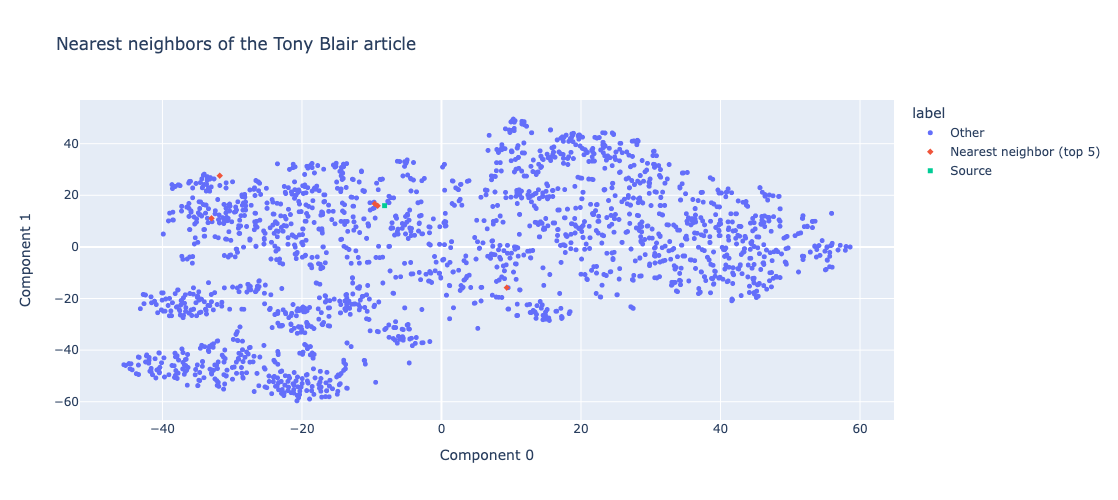

In [20]:
# a 2D chart of nearest neighbors of the Tony Blair article
chart_from_components(
    components=tsne_components,
    labels=tony_blair_labels,
    strings=article_descriptions,
    width=600,
    height=500,
    title="Nearest neighbors of the Tony Blair article",
    category_orders={"label": ["Other", "Nearest neighbor (top 5)", "Source"]},
)

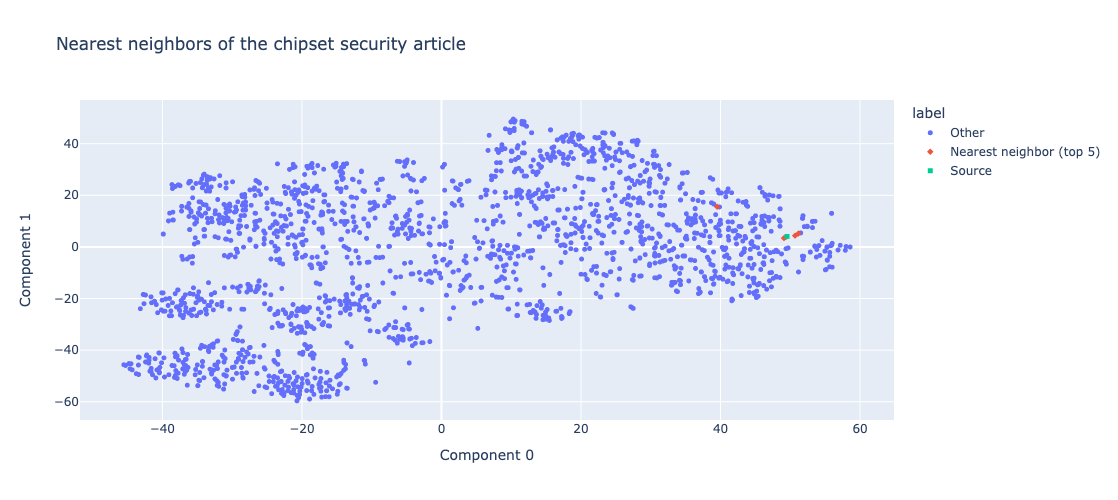

In [21]:
# a 2D chart of nearest neighbors of the chipset security article
chart_from_components(
    components=tsne_components,
    labels=chipset_security_labels,
    strings=article_descriptions,
    width=600,
    height=500,
    title="Nearest neighbors of the chipset security article",
    category_orders={"label": ["Other", "Nearest neighbor (top 5)", "Source"]},
)

### User and product embeddings


In [11]:
# imports
import pandas as pd
import tiktoken

from utils.embeddings_utils import get_embedding

In [12]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

In [13]:
# load & inspect dataset
input_datapath = "data/fine_food_reviews_1k.csv"  # to save space, we provide a pre-filtered dataset
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)

Time   ProductId          UserId  Score  \
0  1351123200  B003XPF9BO  A3R7JR3FMEBXQB      5   
1  1351123200  B003JK537S  A3JBPC3WFUT5ZP      1   

                                             Summary  \
0  where does one  start...and stop... with a tre...   
1                                  Arrived in pieces   

                                                Text  \
0  Wanted to save some to bring to my Chicago fam...   
1  Not pleased at all. When I opened the box, mos...   

                                            combined  
0  Title: where does one  start...and stop... wit...  
1  Title: Arrived in pieces; Content: Not pleased...

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       1000 non-null   int64 
 1   ProductId  1000 non-null   object
 2   UserId     1000 non-null   object
 3   Score      1000 non-null   int64 
 4   Summary    1000 non-null   object
 5   Text       1000 non-null   object
 6   combined   1000 non-null   object
dtypes: int64(2), object(5)
memory usage: 62.5+ KB


In [15]:
# subsample to 1k most recent reviews and remove samples that are too long
top_n = 1000
df = df.sort_values("Time").tail(top_n * 2)  # first cut to first 2k entries, assuming less than half will be filtered out
df.drop("Time", axis=1, inplace=True)

In [16]:
encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(top_n)
len(df)

1000

In [17]:
df.head()

ProductId          UserId  Score  \
0    B003XPF9BO  A3R7JR3FMEBXQB      5   
297  B003VXHGPK  A21VWSCGW7UUAR      4   
296  B008JKTTUA  A34XBAIFT02B60      1   
295  B000LKTTTW  A14MQ40CCU8B13      5   
294  B001D09KAM  A34XBAIFT02B60      1   

                                               Summary  \
0    where does one  start...and stop... with a tre...   
297                   Good, but not Wolfgang Puck good   
296  Should advertise coconut as an ingredient more...   
295                                   Best tomato soup   
294  Should advertise coconut as an ingredient more...   

                                                  Text  \
0    Wanted to save some to bring to my Chicago fam...   
297  Honestly, I have to admit that I expected a li...   
296  First, these should be called Mac - Coconut ba...   
295  I have a hard time finding packaged food of an...   
294  First, these should be called Mac - Coconut ba...   

                                              combined  n_tokens  
0    Title: where does one  start...and stop... wit...        52  
297  Title: Good, but not Wolfgang Puck good; Conte...       178  
296  Title: Should advertise coconut as an ingredie...        78  
295  Title: Best tomato soup; Content: I have a har...       111  
294  Title: Should advertise coconut as an ingredie...        78

In [19]:
df = df.sample(10)

In [21]:
from openai.embeddings_utils import get_embedding

df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))
df.to_csv("fine_food_reviews_with_embeddings_1k.csv")

In [22]:
df

ProductId          UserId  Score                               Summary  \
346  B0030ZLOUC  A1MRWTJP5JWWGV      5                     Premium Dog Food!   
79   B004754DO8   AT4GQGKQ8Z18Z      5          WAGGIN TRAIN CHIK'N BISCUITS   
48   B006WYUFDU   AAYYRMUPU3JDO      5                    Lab puppy loves it   
295  B000LKTTTW  A14MQ40CCU8B13      5                      Best tomato soup   
93   B000YSTGGW   AQH6FCS9F0Z9R      1             Makes babies constipated!   
190  B006LEEWL2  A3FBXJ6D3EQSD5      5               only 5 lollipops remain   
613  B007IEGR9O   A8M34GMW5GF6D      4             girls bettlejuice costume   
982  B005XGH78E  A2YGWCOC3LM3KH      5  Great flavor - spicy but not too hot   
461  B007PA30TG  A29BJSTYH9W3JI      5                          super coffee   
955  B000MUT928   AMV75AVRSNM0L      3           Crunchy strong and ok taste   

                                                  Text  \
346  I ordered about 8pm on 10/23 and got my order ...   
79   MY DOGS LOVE THEM, HOWEVER TENDENCY IS TO GIVE...   
48   My 4 month old lab has been on this for about ...   
295  I have a hard time finding packaged food of an...   
93   Wrongful advertisement! I usually don't write ...   
190  i took the lollipops to work and shared them w...   
613  Fit perfectly. Size is true. Expected exactly ...   
982  I got some of this from a low sodium foods web...   
461  Great coffee and so easy to brew.  This coffee...   
955  I thought the pocket coffee was good, not sure...   

                                              combined  n_tokens  \
346  Title: Premium Dog Food!; Content: I ordered a...       107   
79   Title: WAGGIN TRAIN CHIK'N BISCUITS; Content: ...        60   
48   Title: Lab puppy loves it; Content: My 4 month...        77   
295  Title: Best tomato soup; Content: I have a har...       111   
93   Title: Makes babies constipated!; Content: Wro...       124   
190  Title: only 5 lollipops remain; Content: i too...        51   
613  Title: girls bettlejuice costume; Content: Fit...        41   
982  Title: Great flavor - spicy but not too hot; C...       127   
461  Title: super coffee; Content: Great coffee and...        46   
955  Title: Crunchy strong and ok taste; Content: I...        71   

                                             embedding  
346  [-0.015729352831840515, -0.01920459233224392, ...  
79   [-0.01704832725226879, -0.011330336332321167, ...  
48   [-0.0017943495186045766, -0.008399218320846558...  
295  [-0.001392392092384398, -0.011053348891437054,...  
93   [-0.006622571498155594, 0.004260698799043894, ...  
190  [-0.012875955551862717, -0.010713223367929459,...  
613  [-0.007209081668406725, -0.012445992790162563,...  
982  [0.005446260329335928, 0.003315258538350463, 0...  
461  [0.0037540458142757416, -0.003284381004050374,...  
955  [0.004647246561944485, -0.028131065890192986, ...

### Readin Embedding

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from ast import literal_eval

df = pd.read_csv('data/fine_food_reviews_with_embeddings_1k.csv', index_col=0)  # note that you will need to generate this file to run the code below
df.head(2)

ProductId          UserId  Score  \
0    B003XPF9BO  A3R7JR3FMEBXQB      5   
297  B003VXHGPK  A21VWSCGW7UUAR      4   

                                               Summary  \
0    where does one  start...and stop... with a tre...   
297                   Good, but not Wolfgang Puck good   

                                                  Text  \
0    Wanted to save some to bring to my Chicago fam...   
297  Honestly, I have to admit that I expected a li...   

                                              combined  n_tokens  \
0    Title: where does one  start...and stop... wit...        52   
297  Title: Good, but not Wolfgang Puck good; Conte...       178   

                                             embedding  
0    [0.007018072064965963, -0.02731654793024063, 0...  
297  [-0.003140551969408989, -0.009995664469897747,...

In [3]:
df['babbage_similarity'] = df["embedding"].apply(literal_eval).apply(np.array)
X_train, X_test, y_train, y_test = train_test_split(df, df.Score, test_size = 0.2, random_state=42)

user_embeddings = X_train.groupby('UserId').babbage_similarity.apply(np.mean)
prod_embeddings = X_train.groupby('ProductId').babbage_similarity.apply(np.mean)
len(user_embeddings), len(prod_embeddings)

(577, 706)

In [4]:
from utils.embeddings_utils import cosine_similarity

# evaluate embeddings as recommendations on X_test
def evaluate_single_match(row):
    user_id = row.UserId
    product_id = row.ProductId
    try:
        user_embedding = user_embeddings[user_id]
        product_embedding = prod_embeddings[product_id]
        similarity = cosine_similarity(user_embedding, product_embedding)
        return similarity
    except Exception as e:
        return np.nan

X_test['cosine_similarity'] = X_test.apply(evaluate_single_match, axis=1)
X_test['percentile_cosine_similarity'] = X_test.cosine_similarity.rank(pct=True)

Correlation between user & vector similarity percentile metric and review number of stars (score): 17.25%


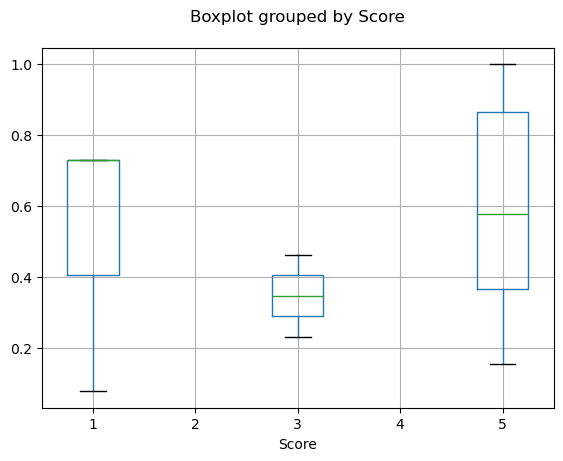

In [7]:
import matplotlib.pyplot as plt
import statsmodels.api as sm


correlation = X_test[['percentile_cosine_similarity', 'Score']].corr().values[0,1]
print('Correlation between user & vector similarity percentile metric and review number of stars (score): %.2f%%' % (100*correlation))

# boxplot of cosine similarity for each score
X_test.boxplot(column='percentile_cosine_similarity', by='Score')
plt.title('')
plt.show()
plt.close()

We can observe a weak trend, showing that the higher the similarity score between the user and the product embedding, the higher the review score. Therefore, the user and product embeddings can weakly predict the review score - even before the user receives the product!

Because this signal works in a different way than the more commonly used collaborative filtering, it can act as an additional feature to slightly improve the performance on existing problems.

https://github.com/openai/openai-cookbook/blob/d891437737cf990a84fc7ac8516d615d7b65540b/examples/User_and_product_embeddings.ipynb#L187